## Data augmentation with Generative Adversial Network (GAN)

In this notebook we use a Deep Convolutional GAN (DCGAN) for data augmentation. DCGAN is like GAN but it uses convolutional layers. The original publication stated some architecture guidelines for stable Deep Convolutional GANs, so I tried to adopt these settings while define and train my models [[1]](#[1]-Unsupervised-Representation-Learning-with-Deep-Convolutional-Generative-Adversarial-Networks). The guidelines are as follows:
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

Besides that I've used the code from our lecture [[2]](#[2]-Deep-Learning-a-gyakorlatban-Python-és-LUA-alapon,-GAN-gyakorlat).


#### [1] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf

#### [2] Deep Learning a gyakorlatban Python és LUA alapon, GAN gyakorlat

Csapó Tamás Gábor

https://colab.research.google.com/drive/1WV25cjucKume0qESqsHzwFtWnLJKPaJT

#### [3] Keras implementations of Generative Adversarial Networks. (Github repository)

Erik Linder-Norén

https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py


## Preprocess & training

First I imported the needed packages:

In [1]:
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.datasets import cifar10
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from PIL import Image
import glob

Using TensorFlow backend.


Next we define a class for DCGAN with the discriminator and generator and the combined GAN model at the end. We use the paramters mentioned before. We've reused some code snippets from our lecture [[2]](#[2]-Deep-Learning-a-gyakorlatban-Python-és-LUA-alapon,-GAN-gyakorlat) and from this repo [[3]](#[3]-Keras-implementations-of-Generative-Adversarial-Networks.-(Github-repository)).

In [2]:
class DCGAN_image():
  
  # discriminator: decides, 
  # wether true or false 
  
    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape = self.img_shape)

        validity = model(img)

        return Model(img, validity)
  
  # generator network: generating image from nois
    def build_generator(self):
        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()
    
        noise = Input(shape = (self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
  
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # here i've tried the following two optimalization algorithm
        # I couldn't find big differences in results
        optimizer_adam = Adam(0.0002, 0.5)
        optimizer_sgd = SGD(lr=0.0005, momentum=0.9, nesterov=True)

        # discriminator build és compile
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', 
                                  optimizer = optimizer_adam,
                                  metrics = ['accuracy'])

        # generator
        self.generator = self.build_generator()
        z = Input(shape = (self.latent_dim,))
        img = self.generator(z)

        # combined model - generator is trained only
        self.discriminator.trainable = False

        # discriminator: true or fals images?
        validity = self.discriminator(img)

        # combined model
        # goal: generator (G) learns, how to cheat discriminator (D)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_adam)

Following functions are visualising the results of the training.

In [3]:
def plot_images(gan, epoch):
    r, c = 5, 2
    noise = np.random.normal(0, 1, ((r*c), gan.latent_dim))
    gen_imgs = gan.generator.predict(noise)

    # scale: -1 -- 1  -> 0 -- 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, ax = plt.subplots(r, c, figsize=(10,10))
    cnt = 0
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs[cnt, :, :, :])
            ax[i,j].axis('off')
            cnt += 1
            
    display.display(plt.gcf())

In [4]:
def show_imgs(X):
    plt.figure(1, figsize=(10,10))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k = k+1
    # show the plot
    plt.show()

In [5]:
def plot_history(d_loss_real_logs, d_loss_fake_logs, g_loss_logs):
    # https://github.com/miranthajayatilake/GANwKeras/blob/master/keras_gan.py
    # plotting logs for the first 1000 epoch
    d_loss_real_logs = np.array(d_loss_real_logs[:1000])
    d_loss_fake_logs = np.array(d_loss_fake_logs[:1000])
    g_loss_logs = np.array(g_loss_logs[:1000])

    # At the end of training plot the losses vs epochs
    fig = plt.figure(figsize=(20,10))
    plt.plot(d_loss_real_logs[:,0], d_loss_real_logs[:,1], label="Discriminator Loss - Real")
    plt.plot(d_loss_fake_logs[:,0], d_loss_fake_logs[:,1], label="Discriminator Loss - Fake")
    plt.plot(g_loss_logs[:,0], g_loss_logs[:,1], label="Generator Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Deep Convolutional Generative Adversarial Network', fontsize=18, y=1.02)
    plt.grid(True)
    plt.show() 

Now, in this function the following sub-tasks will be done:
* load dataset
* prerocessing the input datas
* train the networks and save logs
* and finally, plotting train history

In [6]:
def train_dcgan():    
    ####### load data. #########
    X_train = []

    for file_path in glob.glob('Cropped/*.bmp'):
        X_train.append(np.asarray(Image.open(file_path)))
        
    X_train = np.asarray(X_train)
    print(X_train.shape)
    show_imgs(X_train[:16])

    ####### Preprocessing the input datas. #########
    # scale: [-1, +1] 
    X_train = X_train / 127.5 - 1

    # discriminator outputs
    valid = np.ones((batch_size, 1)) # D(x) = 1
    fake = np.zeros((batch_size, 1)) # D(G(z)) = 0

    ########## train the networks and save logs ##########
    # train G & D, then plotting the generated images
    # Array initialization for logging of the losses
    d_loss_real_logs = []
    d_loss_fake_logs = []
    g_loss_logs = []

    for epoch in range(epochs):

        # random batch of images chosen
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # generating images /batch
        noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))
        gen_imgs = gan.generator.predict(noise)

        # train D
        d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
        d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train G
        g_loss = gan.combined.train_on_batch(noise, valid)

        # log és images  
        if epoch % 100 == 0:
            print(epoch, 'loss_D', d_loss, 'loss_G', g_loss)
            plot_images(gan, epoch)

        # save log
        d_loss_real_logs.append([epoch, d_loss[0]])
        d_loss_fake_logs.append([epoch, d_loss[1]])
        g_loss_logs.append([epoch, g_loss])
       
    
    ########## finally, plotting train history ##########
    # plotting history
    plot_history(d_loss_real_logs, d_loss_fake_logs, g_loss_logs)

## Train network

Some paramter declaration, making instace and call train function.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 9, 9, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 9, 9, 64)          0         
__________

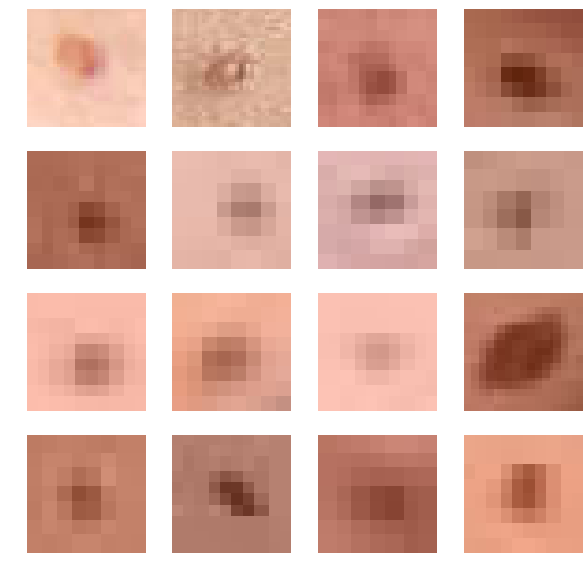

d:\dl_bme\env\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 loss_D [1.0206325 0.3671875] loss_G 0.92856234


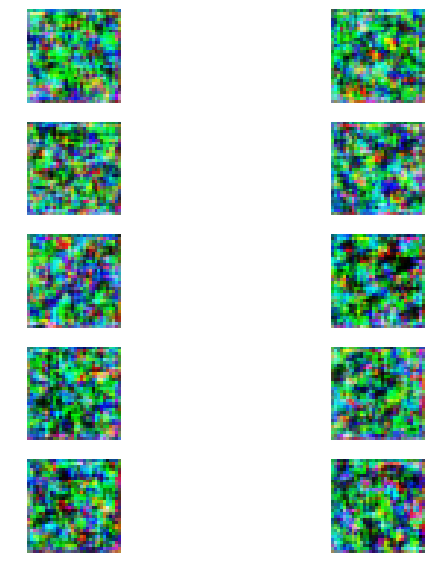

100 loss_D [0.06091696 0.99609375] loss_G 2.5061924


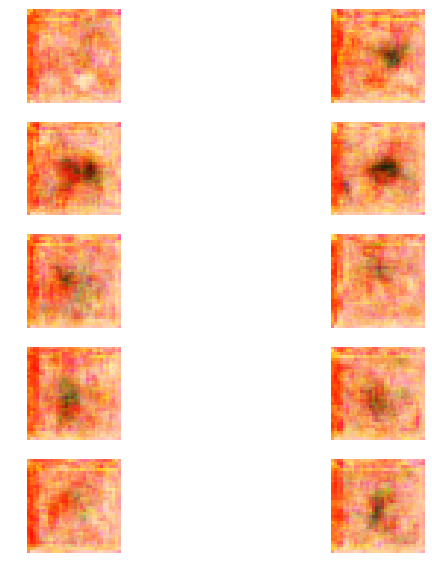

200 loss_D [0.6787344 0.6328125] loss_G 2.2475061


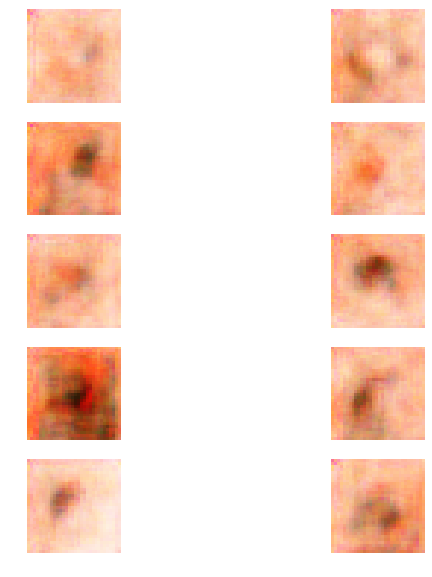

300 loss_D [0.6714196 0.5703125] loss_G 1.778634


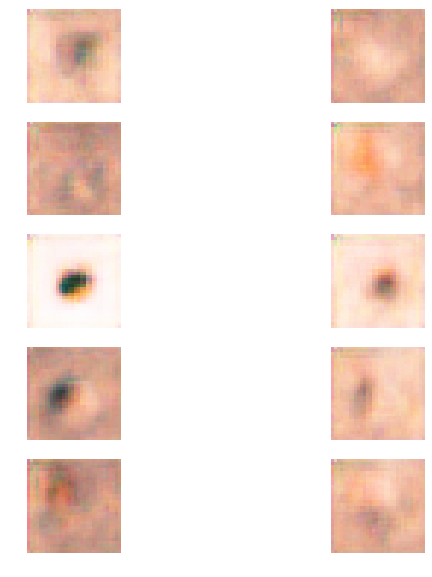

400 loss_D [0.81054103 0.5078125 ] loss_G 1.3469487


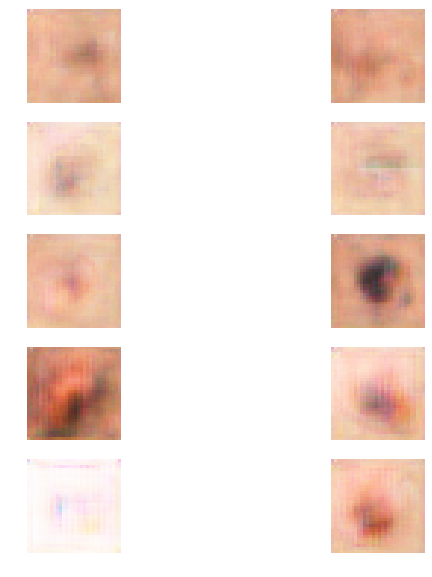

500 loss_D [0.573152   0.68359375] loss_G 1.3321439


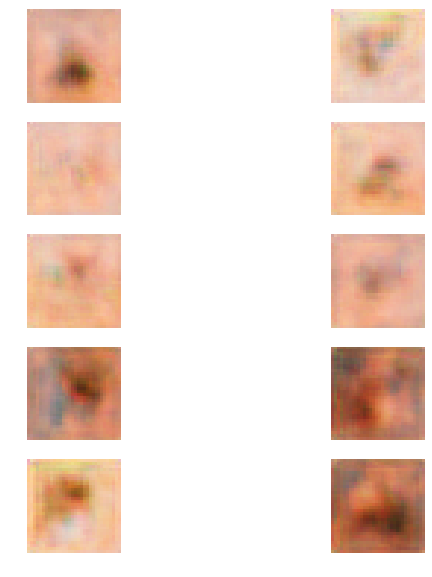

600 loss_D [0.8838687  0.41796875] loss_G 1.1043868


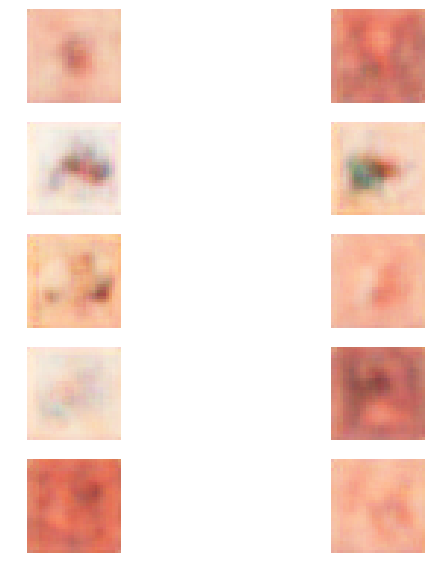

700 loss_D [0.6913858  0.58203125] loss_G 1.1938864


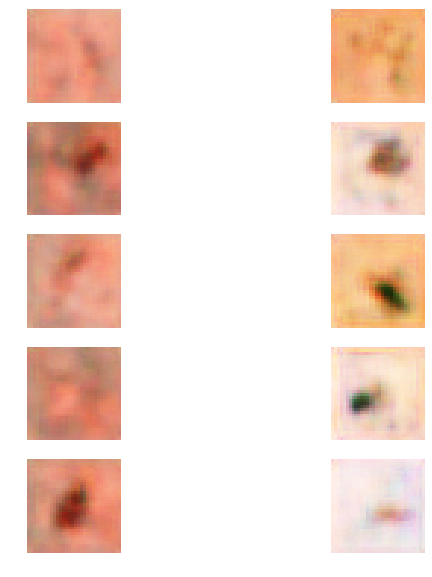

800 loss_D [0.6972355 0.5234375] loss_G 1.1338246


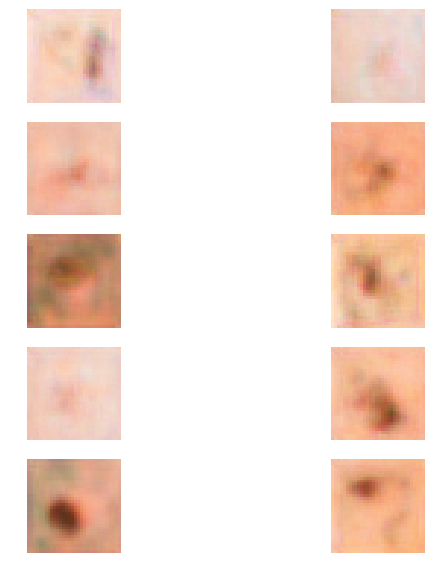

900 loss_D [0.6937361 0.5546875] loss_G 1.0554271


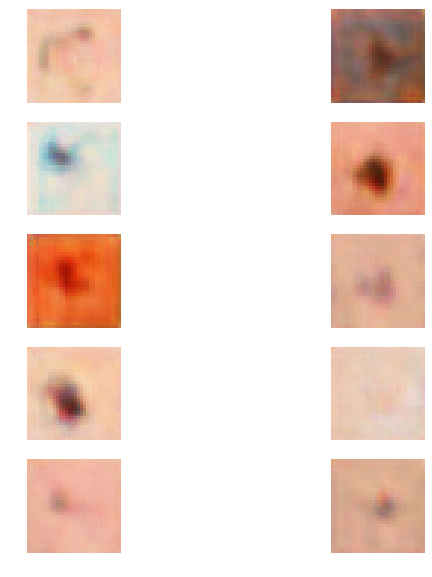

1000 loss_D [0.5811716 0.6875   ] loss_G 1.3149588


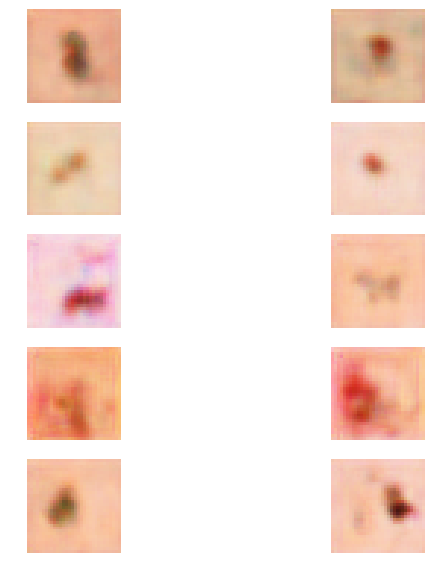

1100 loss_D [0.64506996 0.63671875] loss_G 1.4355938


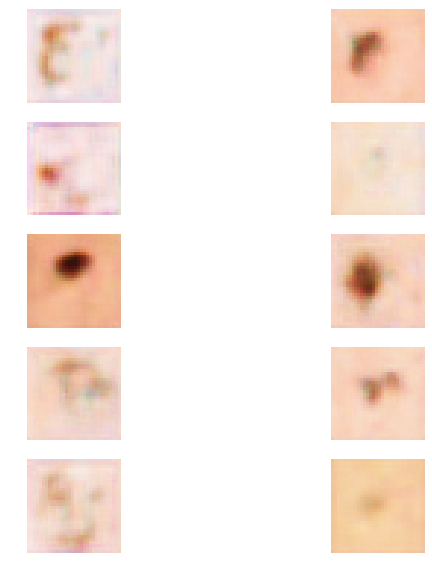

1200 loss_D [0.6873935 0.5859375] loss_G 1.0366489


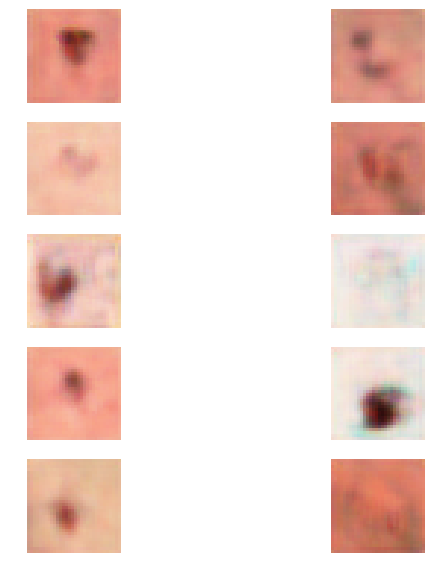

1300 loss_D [0.78807175 0.4609375 ] loss_G 1.0707479


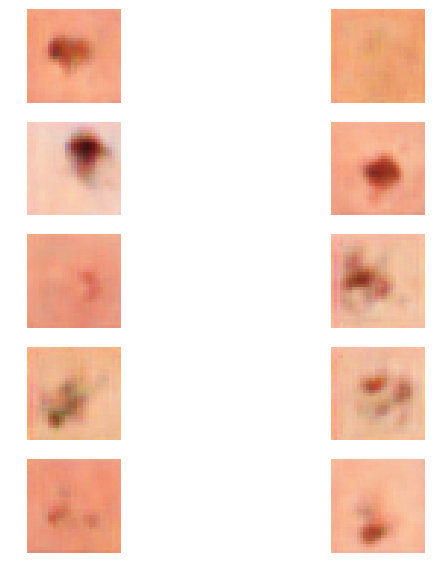

1400 loss_D [0.6607921  0.60546875] loss_G 1.1543168


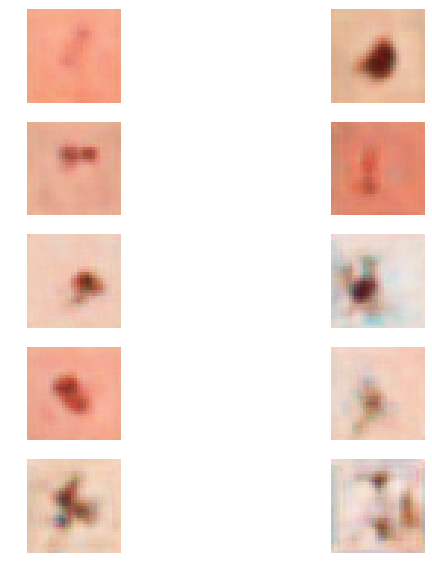

1500 loss_D [0.6535068 0.59375  ] loss_G 1.1147919


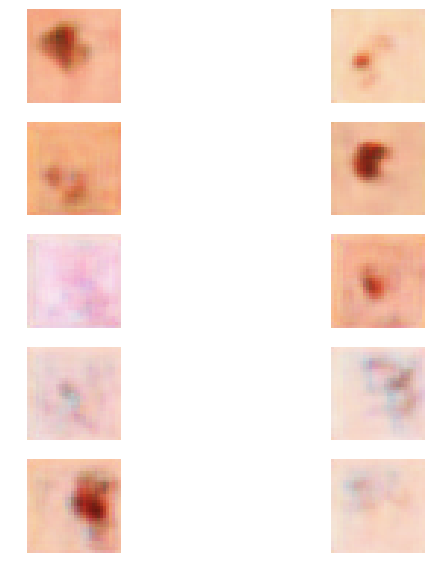

1600 loss_D [0.79227847 0.4453125 ] loss_G 1.0040729


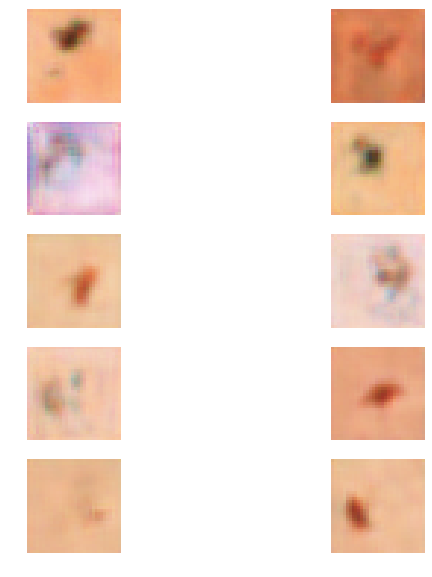

1700 loss_D [0.6442039  0.61328125] loss_G 1.2068667


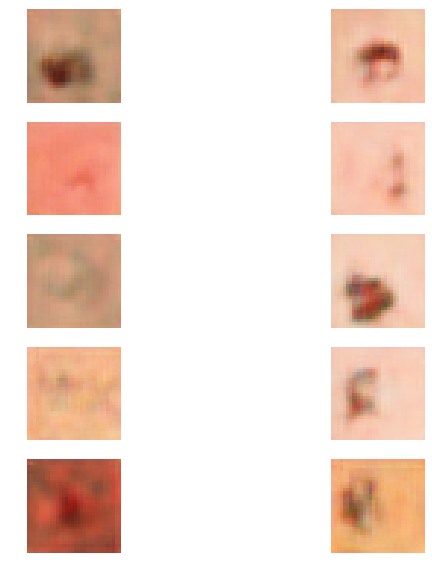

1800 loss_D [0.71597695 0.5546875 ] loss_G 1.1618736


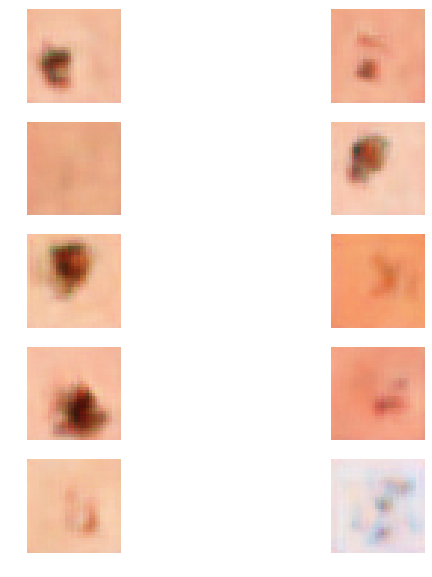

1900 loss_D [0.68187034 0.58984375] loss_G 1.2525258


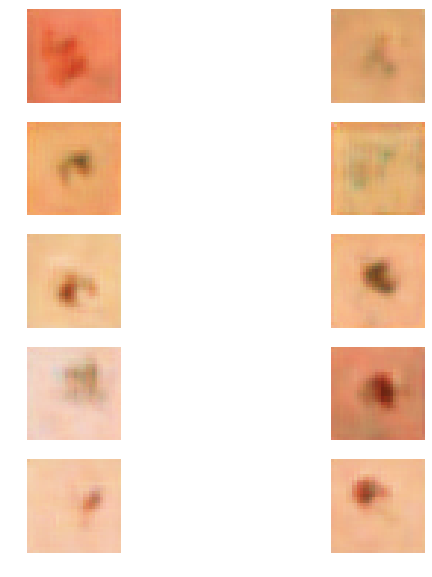

2000 loss_D [0.7512876  0.48828125] loss_G 1.0457108


d:\dl_bme\env\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


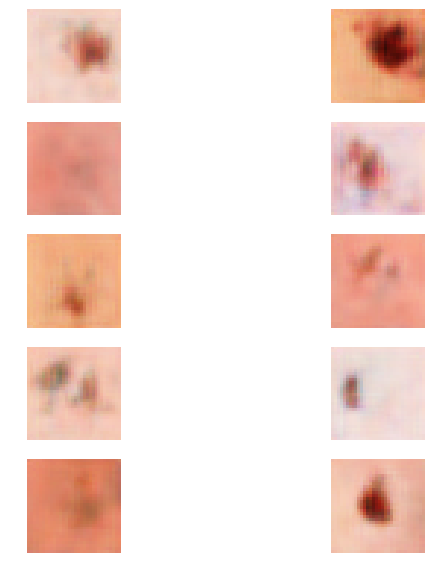

2100 loss_D [0.40976667 0.8125    ] loss_G 1.275575


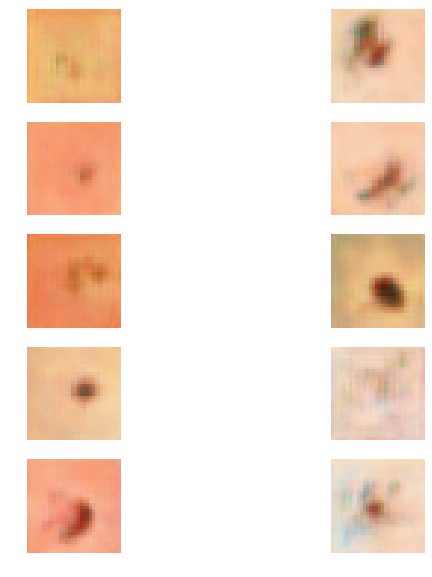

2200 loss_D [0.710678   0.56640625] loss_G 1.0151198


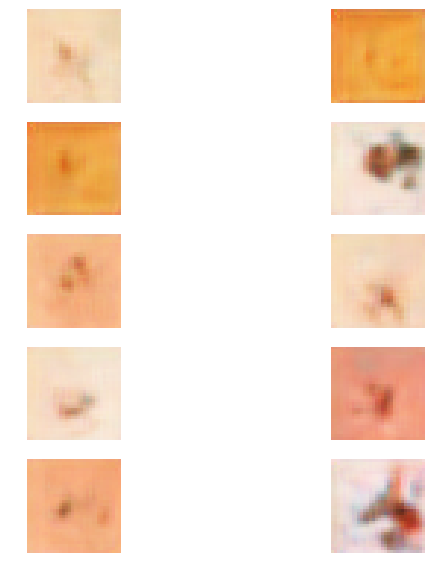

2300 loss_D [0.7312742  0.51953125] loss_G 1.3107872


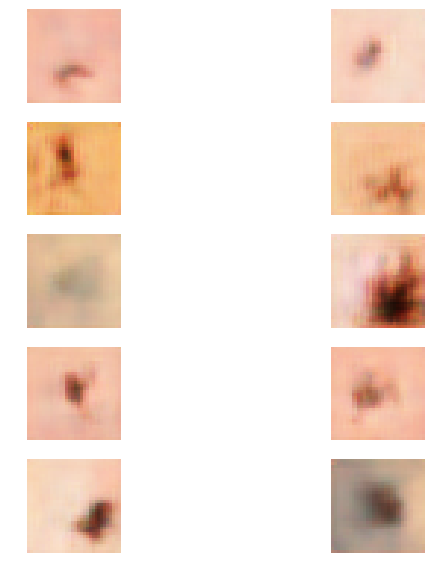

2400 loss_D [0.34660757 0.91796875] loss_G 1.6690814


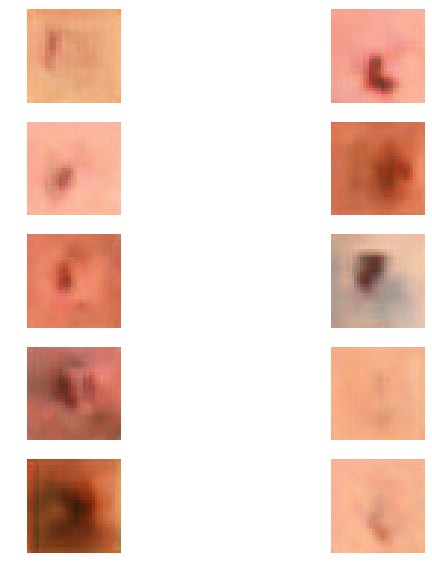

2500 loss_D [0.6317421  0.64453125] loss_G 1.1291137


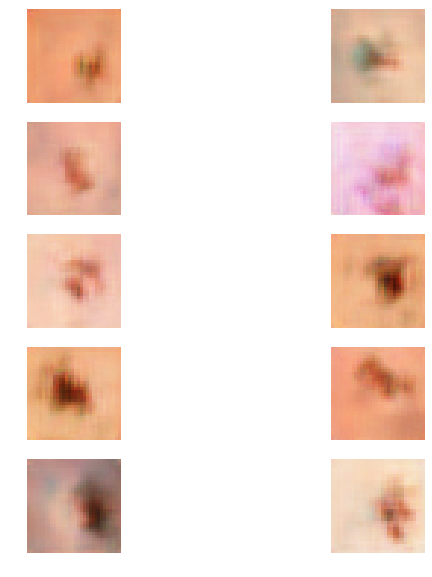

2600 loss_D [0.7620154  0.47265625] loss_G 1.5386095


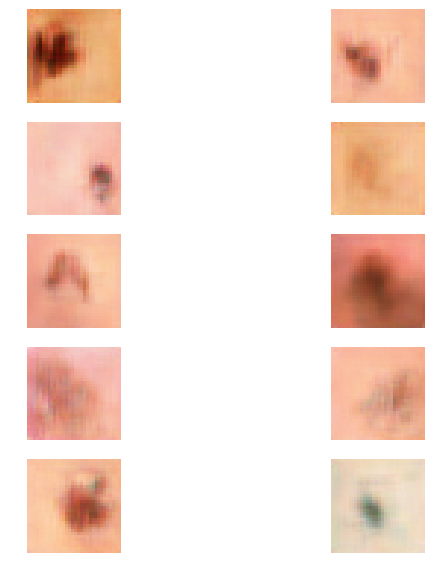

2700 loss_D [0.56482494 0.69140625] loss_G 1.262569


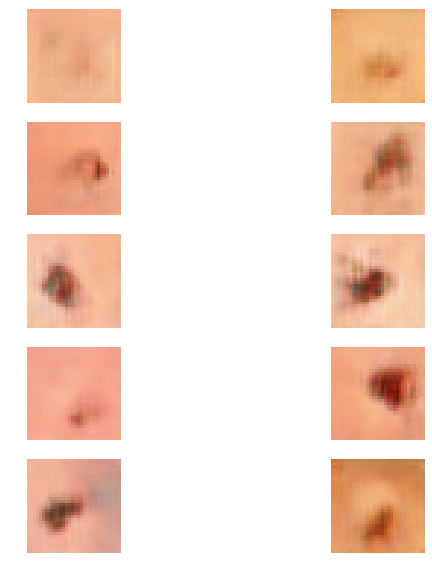

2800 loss_D [0.6217862 0.65625  ] loss_G 1.375753


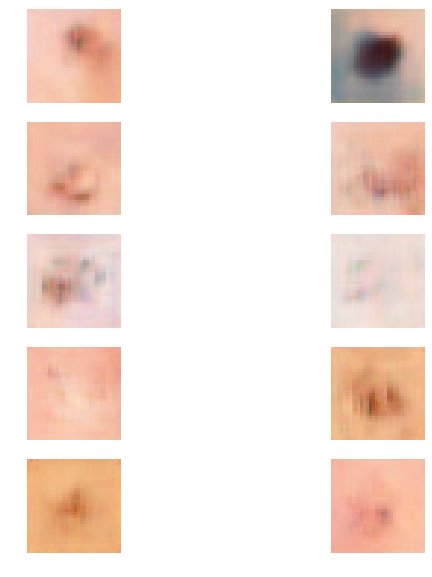

2900 loss_D [0.35130554 0.9453125 ] loss_G 1.506168


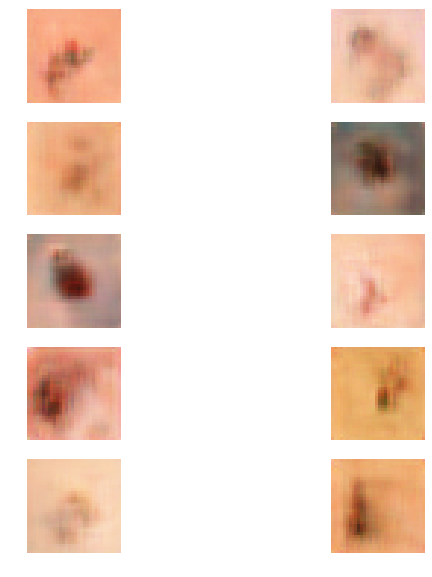

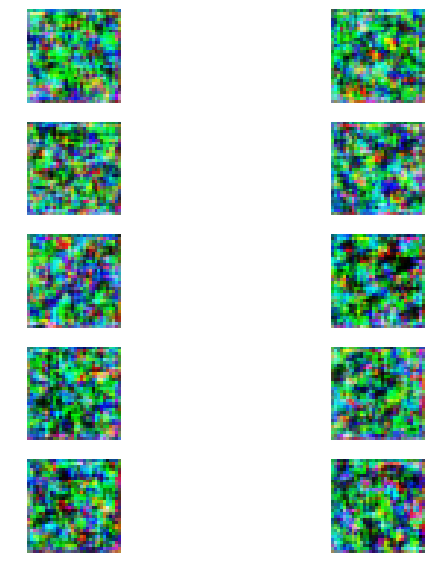

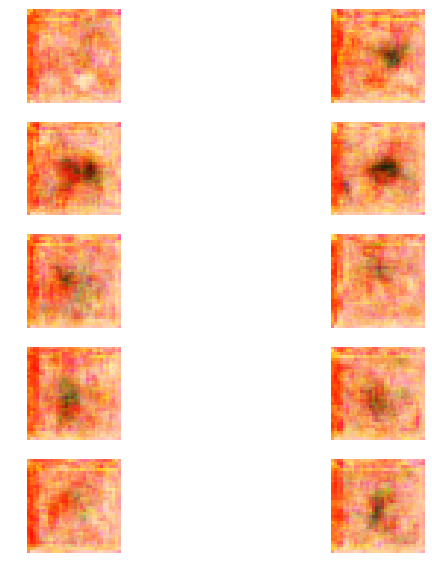

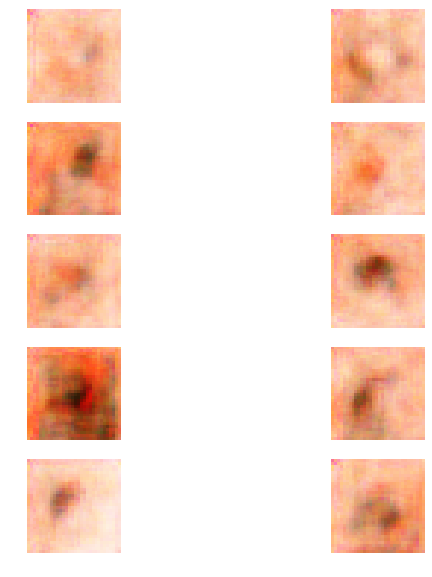

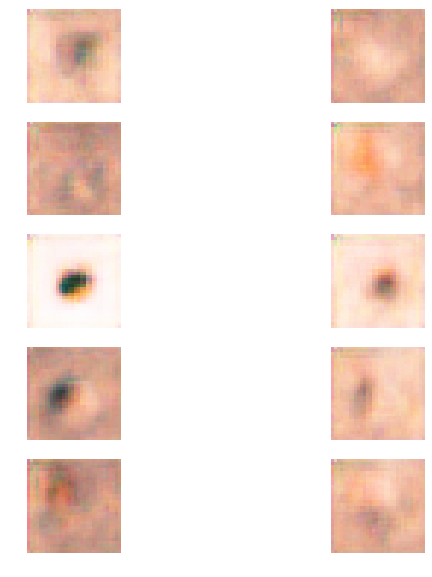

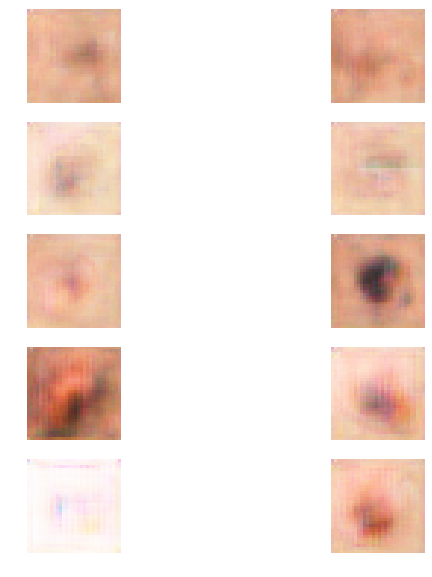

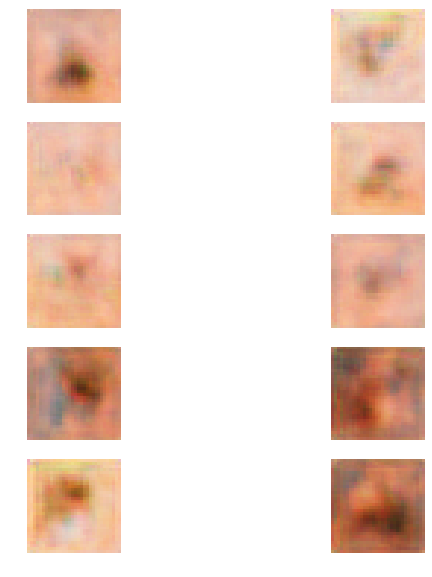

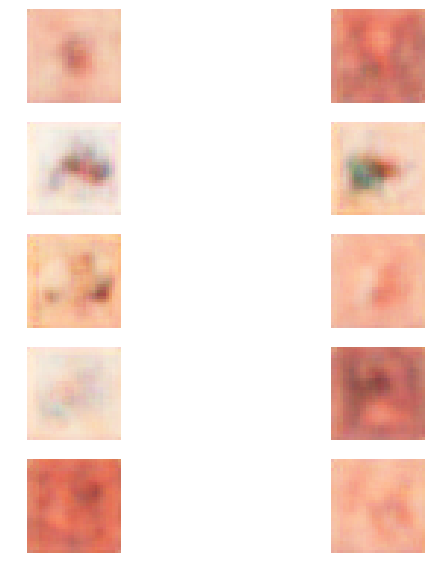

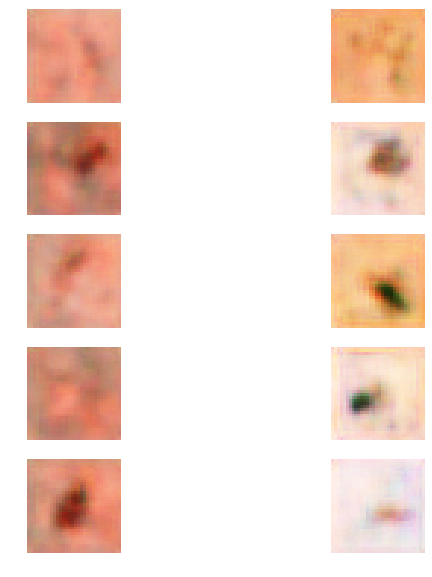

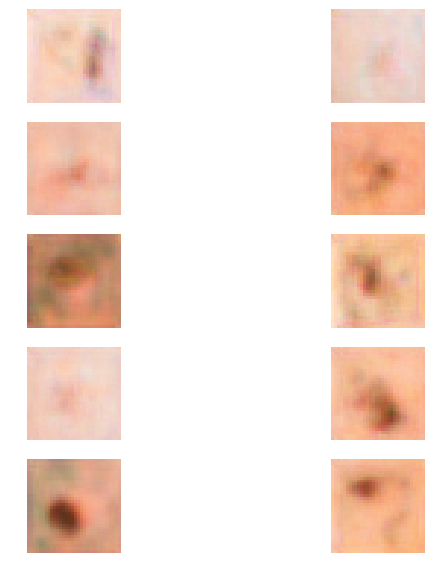

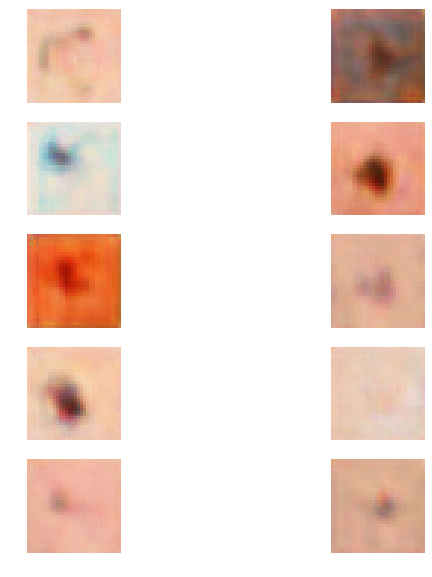

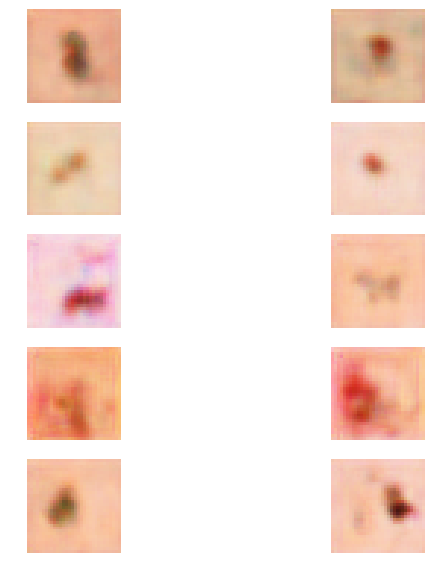

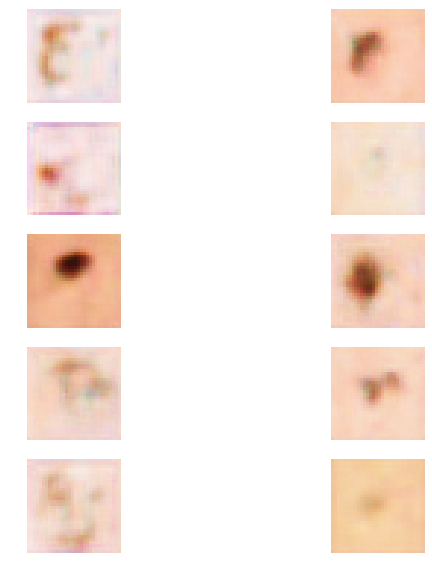

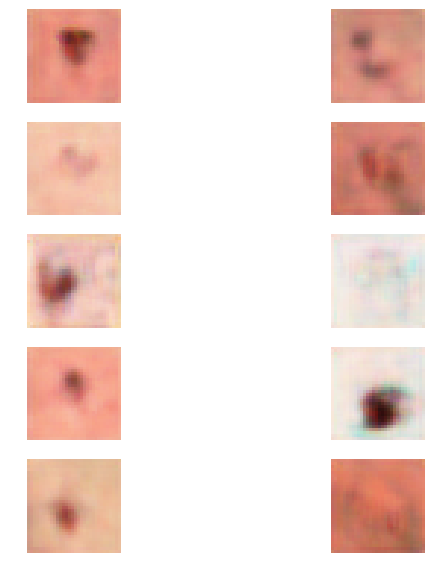

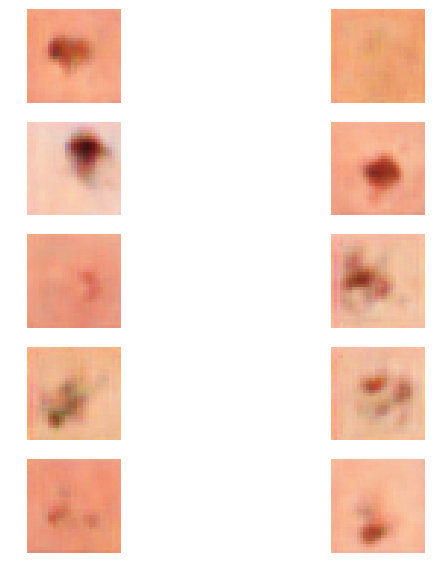

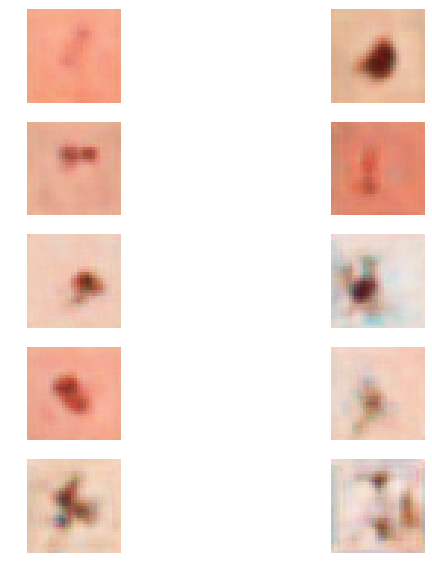

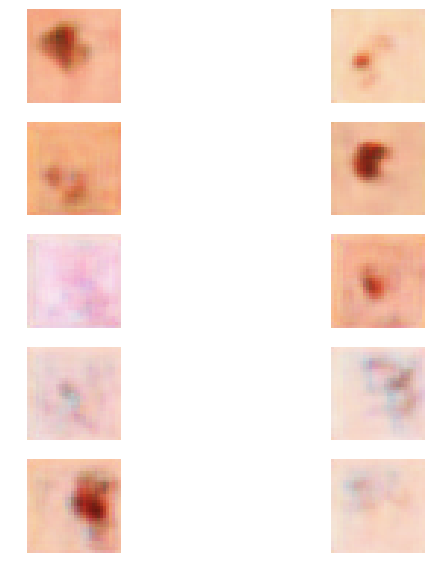

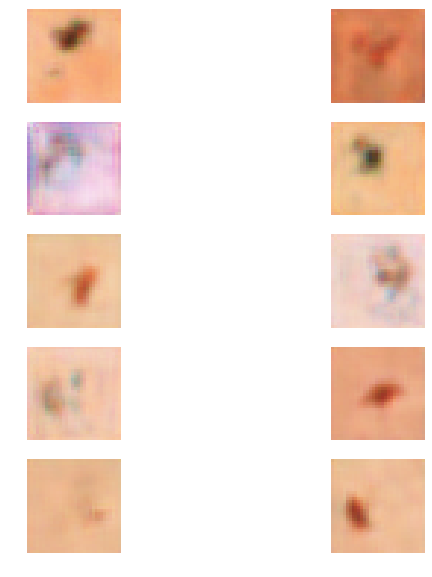

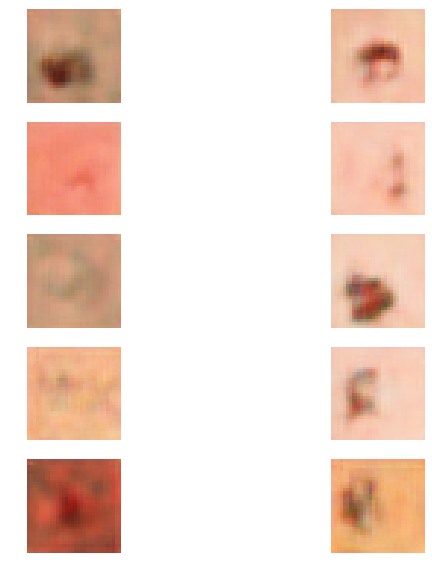

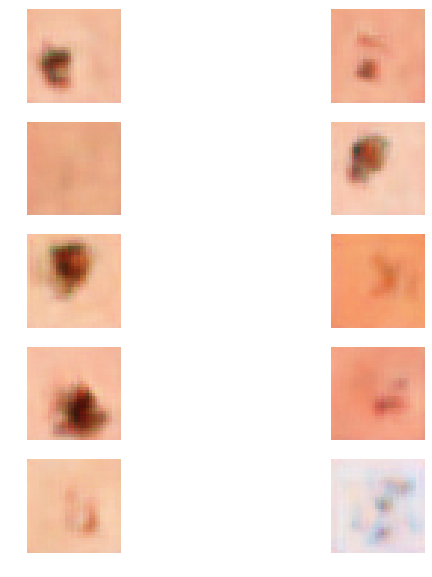

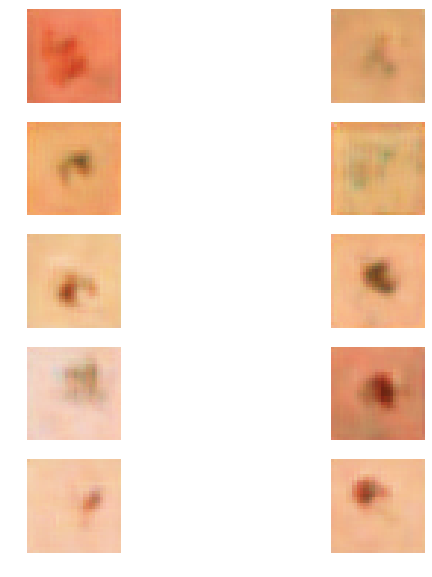

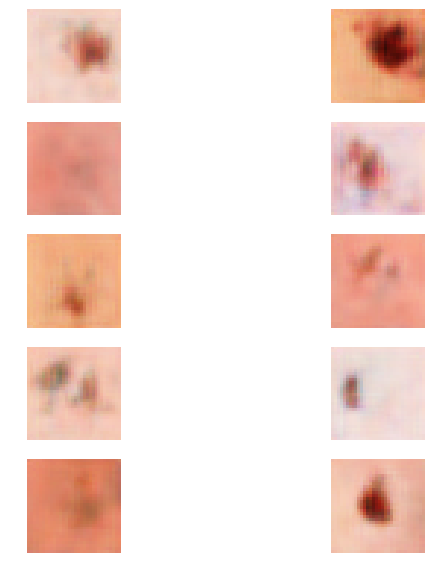

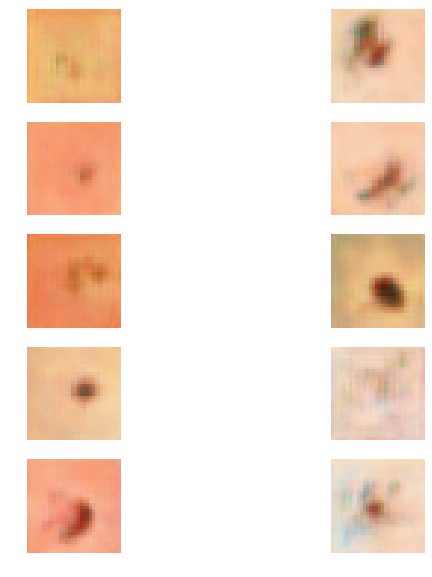

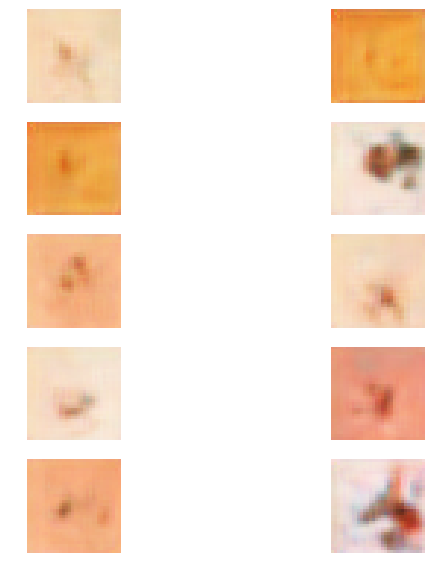

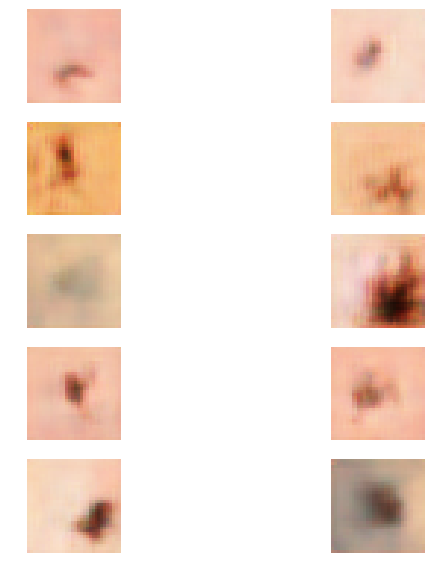

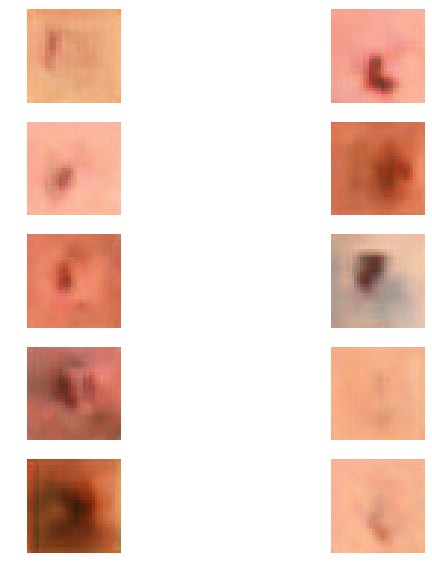

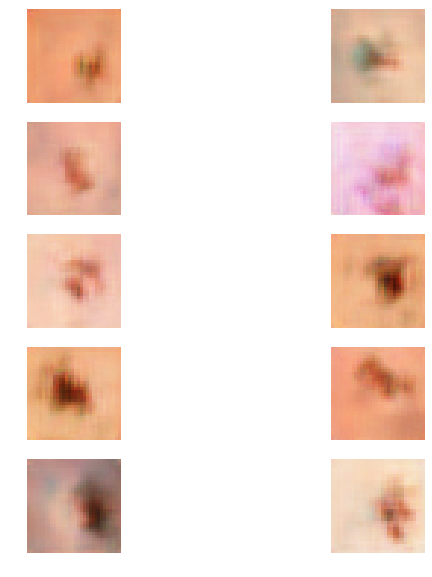

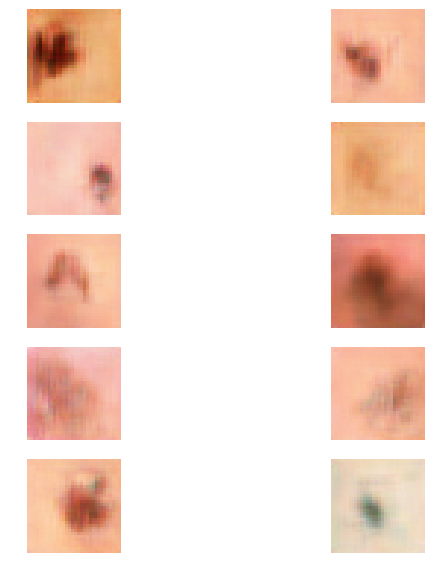

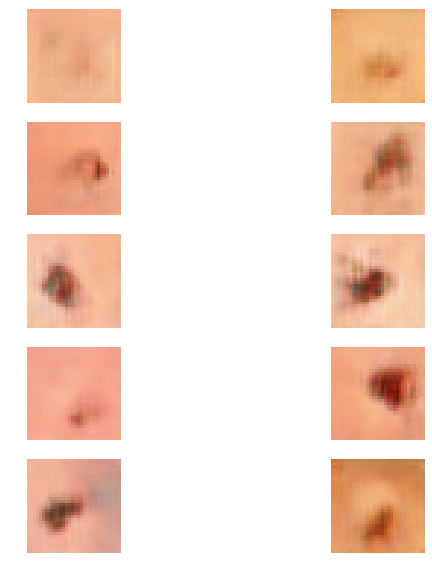

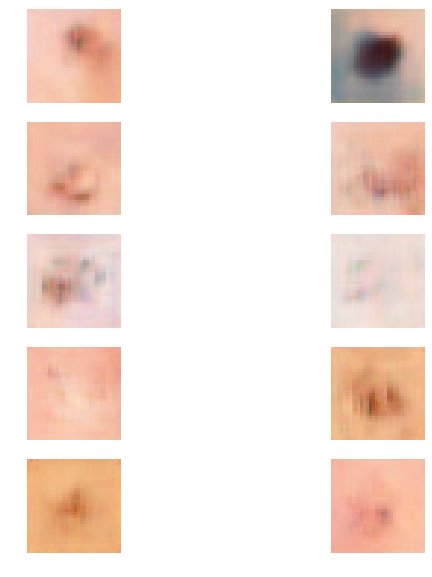

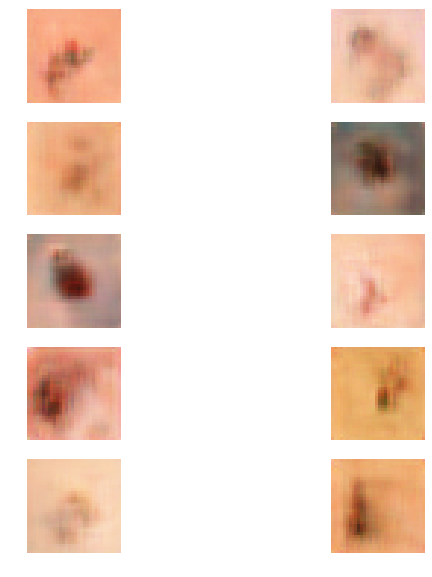

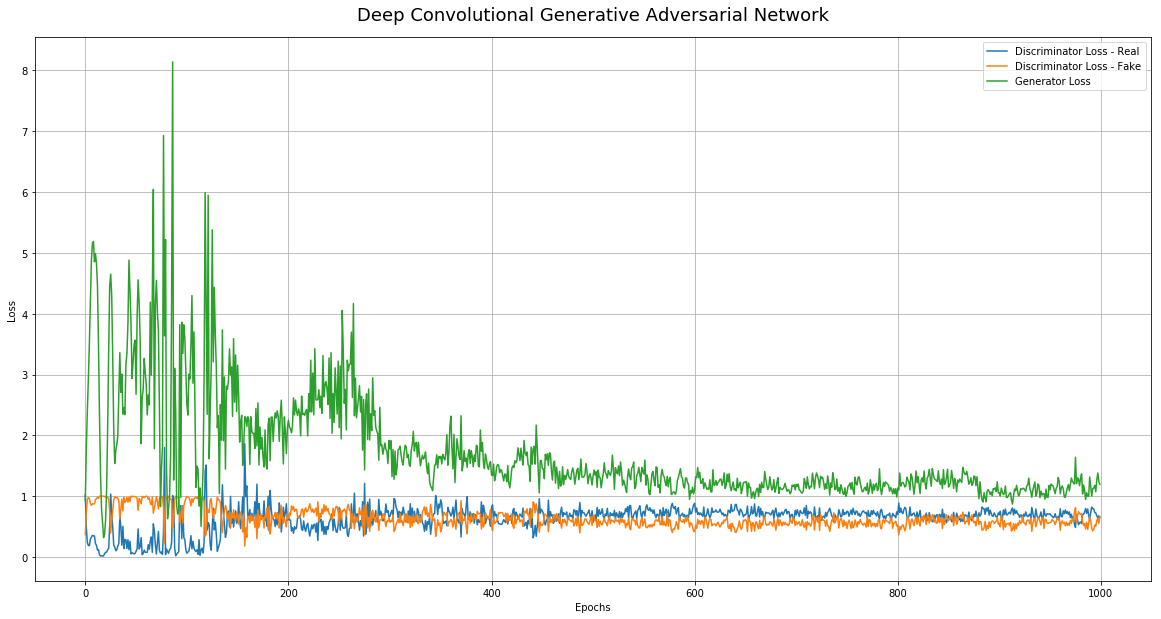

In [7]:
# parametrs for training
epochs = 3000
batch_size = 128
sample_interval = 50

# dcgan class instance
gan = DCGAN_image()

# train with chosen class
train_dcgan()